In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [47]:
import seaborn as sns
from sklearn import preprocessing

### Intro

The aim of this notebook is to understand which varieties are most common by country/region. This is a part of my preparation for my WSET level 2 exam. The dataset is publicly available here: https://www.kaggle.com/zynicide/wine-reviews

### Get Data

In [48]:
folder = os.path.dirname(os.getcwd())
datadir = os.path.join(folder, 'data')
filename = 'winemag-data-130k-v2.csv'
path = os.path.join(datadir, filename)
print(path)

/Users/bramvancamp/repos/research/wine/data/winemag-data-130k-v2.csv


In [49]:
df = pd.read_csv(path, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [50]:
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


### Print out some simple list

In [51]:
df_cou = pd.DataFrame(df['country'].value_counts())
df_cou.columns = ['total']
lst_cou = list(df_cou.index)
lst_cou[:10]

['US',
 'France',
 'Italy',
 'Spain',
 'Portugal',
 'Chile',
 'Argentina',
 'Austria',
 'Australia',
 'Germany']

In [52]:
df_var = pd.DataFrame(df['variety'].value_counts())
df_cou.columns = ['total']
lst_var = list(df_var.index)
lst_var[:10]

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé',
 'Merlot']

### Combine country and variety

In [53]:
df_cv = df.groupby(['country', 'variety'], as_index=False).agg({'title':'count'})
df_cv.rename(columns={'title':'nr'}, inplace=True)

In [54]:
df_hm = df_cv.merge(df_cou['total'], left_on='country', right_index=True, copy=False)
df_hm['share'] = df_hm['nr']/df_hm['total']
df_hm = df_hm[(df_hm['country'].isin(lst_cou[:10]))&(df_hm['variety'].isin(lst_var[:10]))]
df_hm.head(3)

,country,variety,nr,total,share
2,Argentina,Bordeaux-style Red Blend,89,3800,0.023421
8,Argentina,Cabernet Sauvignon,540,3800,0.142105
17,Argentina,Chardonnay,295,3800,0.077632


In [55]:
piv_hm = df_hm.pivot_table(values='nr', index='variety', columns='country', aggfunc=sum, fill_value=0)
piv_hm.fillna(0).astype(int)

country,Argentina,Australia,Austria,Chile,France,Germany,Italy,Portugal,Spain,US
variety,,,,,,,,,,
Bordeaux-style Red Blend,89,29,2,37,4725,0,2,5,9,1824
Cabernet Sauvignon,540,266,5,771,57,0,131,16,53,7315
Chardonnay,295,400,63,516,2808,5,334,17,74,6801
Merlot,59,19,3,258,115,0,150,14,15,2311
Pinot Noir,105,132,99,363,1966,55,6,19,11,9885
Red Blend,234,66,92,409,304,8,3624,7,818,2972
Riesling,2,151,581,24,718,1790,24,4,1,1753
Rosé,38,30,62,44,1923,12,73,235,150,907
Sauvignon Blanc,78,52,128,683,933,0,49,25,33,2163


In [56]:
# prep data for use of sklearn 
arr = piv_hm.values  # numpy array --> sklearn
cols = piv_hm.columns 
ix = piv_hm.index  

In [57]:
arr_scaled = preprocessing.scale(arr)  # standardize to get most/least common variety per country
piv_stan = pd.DataFrame(arr_scaled, columns=cols, index=ix)
piv_stan.round(1)

country,Argentina,Australia,Austria,Chile,France,Germany,Italy,Portugal,Spain,US
variety,,,,,,,,,,
Bordeaux-style Red Blend,-0.4,-0.7,-0.6,-1.2,2.3,-0.3,-0.4,-0.5,-0.5,-0.7
Cabernet Sauvignon,2.5,1.2,-0.6,1.7,-0.9,-0.3,-0.3,-0.3,-0.3,1.2
Chardonnay,0.9,2.4,-0.2,0.7,1.0,-0.3,-0.1,-0.3,-0.2,1.0
Merlot,-0.6,-0.8,-0.6,-0.3,-0.9,-0.3,-0.3,-0.4,-0.4,-0.6
Pinot Noir,-0.3,0.1,-0.0,0.1,0.4,-0.2,-0.4,-0.3,-0.5,2.1
Red Blend,0.5,-0.4,-0.1,0.3,-0.7,-0.3,3.0,-0.5,3.0,-0.3
Riesling,-0.9,0.3,2.9,-1.3,-0.5,3.0,-0.4,-0.5,-0.5,-0.8
Rosé,-0.7,-0.7,-0.3,-1.2,0.4,-0.3,-0.4,2.9,0.1,-1.1
Sauvignon Blanc,-0.5,-0.5,0.1,1.4,-0.3,-0.3,-0.4,-0.2,-0.4,-0.6


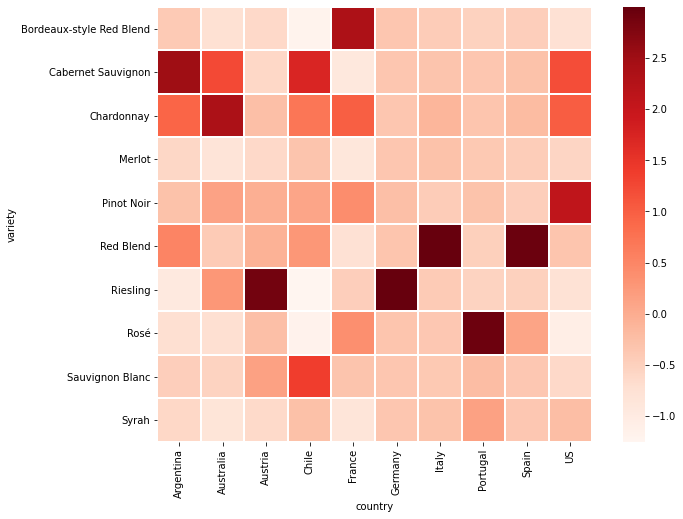

In [58]:
# plot as heatmap
plt.subplots(figsize=(11,8))
ax = sns.heatmap(piv_stan, linewidth=1, cmap="Reds", square=True)
plt.show()

### Add region (province data)

In [59]:
df_geo = df.groupby(['country', 'province','variety'], as_index=False).agg({'title':'count'})
df_geo.rename(columns={'title':'nr'}, inplace=True)
df_geo

,country,province,variety,nr
0,Argentina,Mendoza Province,Bonarda,99
1,Argentina,Mendoza Province,Bordeaux-style Red Blend,85
2,Argentina,Mendoza Province,Bordeaux-style White Blend,1
3,Argentina,Mendoza Province,Cabernet Blend,8
4,Argentina,Mendoza Province,Cabernet Franc,57
...,...,...,...,...
4114,Uruguay,Uruguay,Pinot Noir,1
4115,Uruguay,Uruguay,Red Blend,4
4116,Uruguay,Uruguay,Sauvignon Blanc,1
4117,Uruguay,Uruguay,Tannat,11


In [60]:
df_hm2 = df_geo.merge(df_cou['total'], left_on='country', right_index=True, copy=False)
df_hm2['share'] = df_hm2['nr']/df_hm2['total']
df_hm2 = df_hm2[(df_hm2['country'].isin(lst_cou[:10]))&
                (df_hm2['variety'].isin(lst_var[:20]))&
                (df_hm2['nr']>=50)]
df_hm2['region'] = df_hm2['country']+' / '+df_hm2['province']
df_hm2

,country,province,variety,nr,total,share,region
1,Argentina,Mendoza Province,Bordeaux-style Red Blend,85,3800,0.022368,Argentina / Mendoza Province
7,Argentina,Mendoza Province,Cabernet Sauvignon,486,3800,0.127895,Argentina / Mendoza Province
15,Argentina,Mendoza Province,Chardonnay,265,3800,0.069737,Argentina / Mendoza Province
21,Argentina,Mendoza Province,Malbec,1367,3800,0.359737,Argentina / Mendoza Province
32,Argentina,Mendoza Province,Merlot,52,3800,0.013684,Argentina / Mendoza Province
...,...,...,...,...,...,...,...
4045,US,Washington,Sauvignon Blanc,227,54504,0.004165,US / Washington
4053,US,Washington,Syrah,1129,54504,0.020714,US / Washington
4061,US,Washington,Tempranillo,83,54504,0.001523,US / Washington
4067,US,Washington,White Blend,127,54504,0.002330,US / Washington


In [61]:
piv_hm2 = df_hm2.pivot_table(values='nr', index='region', columns='variety', aggfunc=sum, fill_value=0)
piv_hm2.fillna(0).astype(int)

variety,Bordeaux-style Red Blend,Cabernet Sauvignon,Chardonnay,Malbec,Merlot,Nebbiolo,Pinot Gris,Pinot Noir,Portuguese Red,Red Blend,Rhône-style Red Blend,Riesling,Rosé,Sangiovese,Sauvignon Blanc,Sparkling Blend,Syrah,Tempranillo,White Blend,Zinfandel
region,,,,,,,,,,,,,,,,,,,,
Argentina / Mendoza Province,85,486,265,1367,52,0,0,57,0,206,0,0,0,0,64,0,0,0,0,0
Argentina / Other,0,54,0,143,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Australia / Australia Other,0,0,87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Australia / South Australia,0,180,150,0,0,0,0,0,0,0,0,109,0,0,0,0,0,0,0,0
Australia / Victoria,0,0,0,0,0,0,0,74,0,0,0,0,0,0,0,0,0,0,0,0
Australia / Western Australia,0,53,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Austria / Kamptal,0,0,0,0,0,0,0,0,0,0,0,154,0,0,0,0,0,0,0,0
Austria / Kremstal,0,0,0,0,0,0,0,0,0,0,0,127,0,0,0,0,0,0,0,0
Austria / Niederösterreich,0,0,0,0,0,0,0,0,0,0,0,87,0,0,0,0,0,0,0,0


In [62]:
# prep data for use of sklearn 
arr2 = piv_hm2.values  # numpy array --> sklearn
cols2 = piv_hm2.columns 
ix2 = piv_hm2.index  

arr_scaled2 = preprocessing.scale(arr2, axis=1)  # standardize to get most/least common variety per country
piv_stan2 = pd.DataFrame(arr_scaled2, columns=cols2, index=ix2)

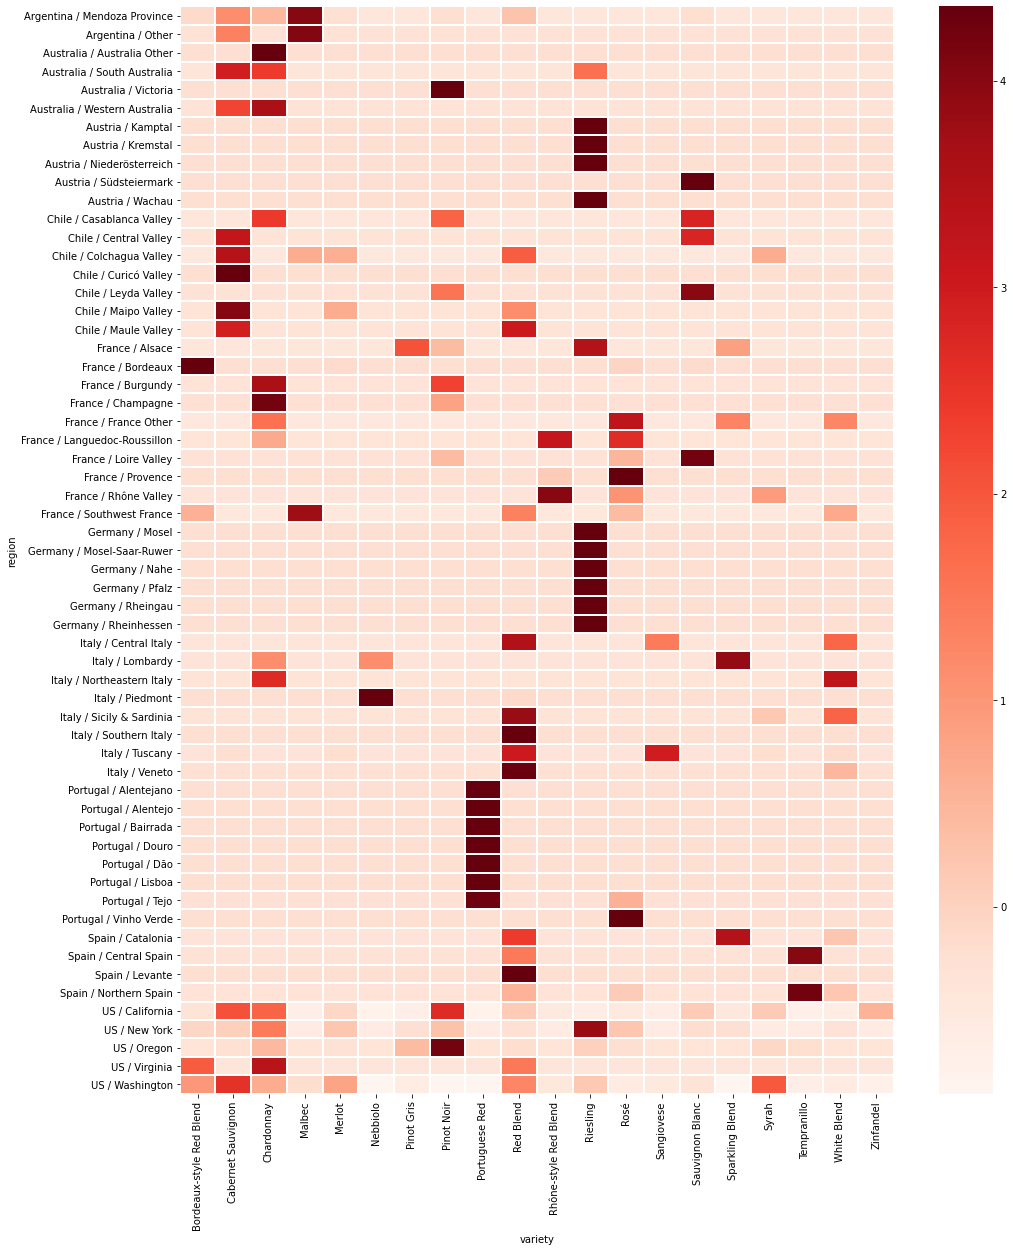

In [63]:
# plot as heatmap
plt.subplots(figsize=(16,20))
ax = sns.heatmap(piv_norm2, linewidth=1, cmap="Reds")
plt.show()